# Humanizing Customer Complaints 
### A model that can correctly classify a customer complaint according to it’s product type, with an accuracy of 83%.

### **Problem Defination:** a supervised (labelled) text multi-class classification problem, of which our goal is to make a prediction (assign to correct category) with a new input (complaint).

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"koushiktcs12","key":"4004aba149297e662c11063e50b8ef45"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                     title                                         size  lastUpdated          downloadCount  
------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
unanimad/us-election-2020                               US Election 2020                             416KB  2020-11-10 14:13:28           2010  
manchunhui/us-election-2020-tweets                      US Election 2020 Tweets                      353MB  2020-11-09 18:51:59           1595  
antgoldbloom/covid19-data-from-john-hopkins-university  COVID-19 data from John Hopkins University     2MB  2020-11-11 06:04:12            354  
headsortails/us-election-2020-presidential-debates      US Election 2020 - Presidential Debates      199MB  2020-10-23 16:56:10            337  
etsc9287/2020-general-election-polls                    2020 General Election Polls                  109KB  2020-02-09 08:20:59   

In [3]:
!kaggle datasets download -d watts2/glove6b50dtxt
!kaggle datasets download -d danielwillgeorge/glove6b100dtxt
!kaggle datasets download -d incorpes/glove6b200d
!kaggle datasets download -d thanakomsn/glove6b300dtxt
!kaggle datasets download -d leadbest/googlenewsvectorsnegative300
!unzip \*.zip  && rm *.zip
!ls

 84% 57.0M/67.7M [00:00<00:00, 53.6MB/s]
100% 67.7M/67.7M [00:00<00:00, 92.8MB/s]
 80% 105M/131M [00:01<00:00, 53.8MB/s] 
100% 131M/131M [00:01<00:00, 71.8MB/s]
 99% 256M/259M [00:03<00:00, 44.8MB/s]
100% 259M/259M [00:03<00:00, 77.0MB/s]
 97% 374M/386M [00:05<00:00, 41.3MB/s]
100% 386M/386M [00:05<00:00, 70.7MB/s]
 17% 561M/3.17G [00:08<00:41, 67.3MB/s]
User cancelled operation
Archive:  glove6b50dtxt.zip
  inflating: glove.6B.50d.txt        

Archive:  glove6b200d.zip
  inflating: glove.6B.200d.txt       

Archive:  googlenewsvectorsnegative300.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  glove6b300dtxt.zip
  inflating: glove.6B.300d.txt       

Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       

4 archives were successfully processed.
1 file had n

In [4]:
!pip install spacy-langdetect
!pip install language-detector
!pip install symspellpy
!pip install sentence-transformers
!pip install --upgrade gensim
!pip install pyLDAvis3
!pip install stop-words
!python -m pip install -U pyLDAvis
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')

     |████████████████████████████████| 1.0MB 4.7MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993461 sha256=1c15613c744ce5971aa9f1cb79a3c86b08d20163f84ae69aac6f52feae3650e4
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect
  Created wheel for language-detector: filename=language_detector-5.0.2-cp36-none-any.whl size=7055 sha256=5bbadaff51913fb607e6d51da520748d34e3f0fddc1c9b5b4d05beaa4321fa3a
  Stored in directory: /root/.cache/pip/wheels/7d/37/fa/2098a4aa6c0d94d6ddff0d3a79669e12bc4f7baca8a760b3db
Successfully built language-detector
     |████████████████████████████████| 2.6MB 4.7MB/s 
     |████████████████████████████████| 71kB 3.1MB/s 
     |████████████████████████████████| 1.1MB 6.9MB/s 
     |████████████████████████████████| 1.1MB 9.8MB/s 
     |████████████████████████████████| 890kB 12.7MB/s 
     |████████████████████████████████| 3.0MB 15.6MB/s 
 

True

# Section 1: Importing Packages and Loading Data

In [5]:
import numpy as np
import pandas as pd
seed = 69 # set random seed for whole document

# Graph plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Displaying dataframes
from IPython.display import display

# Natural Language Processing Thingamajibs
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.models import Word2Vec, word2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import gensim

# Classifiers
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV

# Metrics to score classifiers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, log_loss

# Data splitting, CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

# Lifesaver
import pickle
from google.colab import files

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **Data Source** Kaggle https://www.kaggle.com/cfpb/us-consumer-finance-complaints
### Original data source: https://files.consumerfinance.gov/ccdb/complaints.csv.zip

In [10]:
from google.colab import drive
drive.mount('/content/drive')
!kaggle datasets download -d cfpb/us-consumer-finance-complaints
!unzip \*.zip  && rm *.zip
!lsY

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 98% 83.0M/84.5M [00:01<00:00, 54.0MB/s]
100% 84.5M/84.5M [00:01<00:00, 75.9MB/s]
Archive:  glove6b50dtxt.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N

Archive:  glove6b200d.zip

Archive:  googlenewsvectorsnegative300.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  glove6b300dtxt.zip

Archive:  glove6b100dtxt.zip

Archive:  us-consumer-finance-complaints.zip
  inflating: consumer_complaints.csv  
  inflating: database.sqlite         

5 archives were successfully processed.
1 file had no zipfile directory.
consumer_complaints.csv  glove.6B.200d.txt   glove6b50dtxt.zip
database.sqlite		 glove6b200d.zip     googlenewsve

In [11]:
# # Load CSV file
df= pd.read_csv(r'consumer_complaints.csv')
# This step is not executable because the .csv file is not in the drive
#df= pd.read_csv(r'/content/drive/My Drive/CFPB LDA/complaints.csv')
df.info()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [12]:
# Column Cleaning First. Columns are super nastily named
'''df.rename(columns={'Date received':'DATE_RECEIVED',
                  'Product':'PRODUCT',
                  'Sub-product':'SUB_PRODUCT',
                  'Issue':'ISSUE',
                  'Sub-issue':'SUB_ISSUE',
                  'Consumer complaint narrative':'CONSUMER_COMPLAINT_NARRATIVE',
                  'Company public response':'COMPANY_PUBLIC_RESPONSE',
                   'Company':'COMPANY',
                   'State':'STATE',
                   'ZIP code':'ZIP_CODE',
                   'Tags':'TAGS',
                   'Consumer consent provided?':'CONSUMER_CONSENT_PROVIDED',
                   'Subbmited via':'SUBMITTED_VIA',
                   'Date sent to company':'DATE_SENT_TO_COMPANY',
                   'Company response to consumer':'COMPANY_RESPONSE_TO_CONSUMER',
                   'Timely response?':'TIMELY_RESPONSE',
                   'Consumer disputed?':'CONSUMER_DISPUTED',
                   'Complaint ID':'COMPLAINT_ID'
                  }, inplace=True)'''

                  # Column Cleaning First. Columns are super nastily named
df.rename(columns={'date_received':'DATE_RECEIVED',
                  'product':'PRODUCT',
                  'sub_product':'SUB_PRODUCT',
                  'issue':'ISSUE',
                  'sub_issue':'SUB_ISSUE',
                  'consumer_complaint_narrative':'CONSUMER_COMPLAINT_NARRATIVE',
                  'company_public_response':'COMPANY_PUBLIC_RESPONSE',
                   'company':'COMPANY',
                   'state':'STATE',
                   'zipcode':'ZIP_CODE',
                   'tags':'TAGS',
                   'consumer_consent_provided':'CONSUMER_CONSENT_PROVIDED',
                   'submitted_via':'SUBMITTED_VIA',
                   'date_sent_to_company':'DATE_SENT_TO_COMPANY',
                   'company_response_to_consumer':'COMPANY_RESPONSE_TO_CONSUMER',
                   'timely_response':'TIMELY_RESPONSE',
                   'consumer_disputed?':'CONSUMER_DISPUTED',
                   'complaint_id':'COMPLAINT_ID'
                  }, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   DATE_RECEIVED                 555957 non-null  object
 1   PRODUCT                       555957 non-null  object
 2   SUB_PRODUCT                   397635 non-null  object
 3   ISSUE                         555957 non-null  object
 4   SUB_ISSUE                     212622 non-null  object
 5   CONSUMER_COMPLAINT_NARRATIVE  66806 non-null   object
 6   COMPANY_PUBLIC_RESPONSE       85124 non-null   object
 7   COMPANY                       555957 non-null  object
 8   STATE                         551070 non-null  object
 9   ZIP_CODE                      551452 non-null  object
 10  TAGS                          77959 non-null   object
 11  CONSUMER_CONSENT_PROVIDED     123458 non-null  object
 12  SUBMITTED_VIA                 555957 non-null  object
 13 

In [14]:
df_complaints_issue_bkp = df
df = df[df["CONSUMER_COMPLAINT_NARRATIVE"].notnull() == True]
df = df.drop_duplicates()
print(df.shape)
df['Text_Length'] = df["CONSUMER_COMPLAINT_NARRATIVE"].str.len()
print(df.shape)

(66806, 18)
(66806, 19)


In [15]:
df = df[['PRODUCT','ISSUE', 'CONSUMER_COMPLAINT_NARRATIVE']]
df['PRODUCT_ISSUE'] = df["PRODUCT"] +'_'+ df["ISSUE"]
df.groupby('PRODUCT_ISSUE').head(2).to_csv('Sample_text_demo.csv')

In [16]:
# Exploring the number of mutli-class categories we have
print('--------------')
print('Categories in PRODUCT column:')
print('--------------\n')
print(df['PRODUCT'].unique(), '\n')
print('--------------')
print('# of unique categories: ', df['PRODUCT'].nunique())
print('--------------')

--------------
Categories in PRODUCT column:
--------------

['Debt collection' 'Consumer Loan' 'Mortgage' 'Credit card'
 'Credit reporting' 'Student loan' 'Bank account or service' 'Payday loan'
 'Money transfers' 'Other financial service' 'Prepaid card'] 

--------------
# of unique categories:  11
--------------


In [17]:
## Combining Loans together to make this a simplier classification problem

df.replace('Student loan', 'Loan', inplace=True)
df.replace('Consumer Loan', 'Loan', inplace=True)
df.replace('Payday loan', 'Loan', inplace=True)
df.replace('Vehicle loan or lease', 'Loan', inplace=True)
df.replace('Payday loan, title loan, or personal loan', 'Loan', inplace=True)
df.replace('Money transfer, virtual currency, or money service', 'Prepaid card', inplace=True)


# Placing Virtual currency into Prepaid card
df.replace('Virtual currency', 'Prepaid card', inplace=True)

## PRODUCT column, we observe 18 classes with the following distribution:

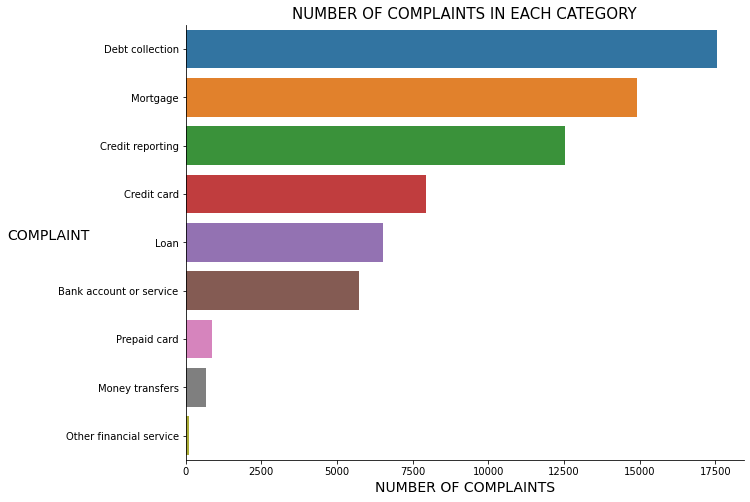

In [18]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df, 
                   order=df['PRODUCT'].value_counts().index)

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, size=14, labelpad=10)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
            
plt.savefig('freq_pc_uncombined_class.png', transparency=True)

## Some of the classes (products), however, overlap. For instance, Credit card or prepaid card clash with Credit card and Prepaid card. 

Product wise
Credit card            17552
Credit reporting                   14919
Credit card           12526
Credit card                 7929
Prepaid card     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Prepaid card              666
Prepaid card      110

In [19]:
product_nm = 'Prepaid card'

In [20]:
df=df[(df['PRODUCT']==product_nm)]
print(df[['PRODUCT','ISSUE']].value_counts())

PRODUCT       ISSUE                                  
Prepaid card  Unauthorized transactions/trans. issues    298
              Managing, opening, or closing account      261
              Fraud or scam                              179
              Adding money                                65
              Fees                                        40
              Advertising, marketing or disclosures       11
              Overdraft, savings or rewards features       7
dtype: int64


In [21]:
df_complaints_issue_bkp = df
df = df[df["CONSUMER_COMPLAINT_NARRATIVE"].notnull() == True]
df = df.drop_duplicates()
print(df.shape)
df['Text_Length'] = df["CONSUMER_COMPLAINT_NARRATIVE"].str.len()
print(df.shape)

(860, 4)
(860, 5)


## Section 1.1: Data Cleaning

### Section 1.1.1: Dropping all rows that do not have Customer Complaint entries in them

In [22]:
df.dropna(axis=0, subset=['CONSUMER_COMPLAINT_NARRATIVE'],inplace=True)

### Section 1.1.2: Subsetting Dataframe for Text Multi-Classification Problem

In [23]:
df.head()

PRODUCT  ... Text_Length
197552  Prepaid card  ...         253
200639  Prepaid card  ...          97
201463  Prepaid card  ...        1693
202094  Prepaid card  ...        1158
202668  Prepaid card  ...         485

[5 rows x 5 columns]

In [24]:
# Subsetting dataframe into columns useful for our text multi-classification problem
df_pc_issue_and_complaint = df[['ISSUE', 'CONSUMER_COMPLAINT_NARRATIVE']]

# Renaming columns to something easier
df_pc_issue_and_complaint.rename(columns={'CONSUMER_COMPLAINT_NARRATIVE':'CONSUMER_COMPLAINT'},inplace=True) 
df.rename(columns={'CONSUMER_COMPLAINT_NARRATIVE':'CONSUMER_COMPLAINT'},inplace=True) 

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
grouped_counts = df_pc_issue_and_complaint.groupby(['ISSUE'])['CONSUMER_COMPLAINT'].count()
grouped_counts_flt = grouped_counts.loc[grouped_counts.values>=10]
grouped_counts_flt = pd.DataFrame(grouped_counts_flt)
grouped_counts_flt = grouped_counts_flt.reset_index()
df_product_issue_and_complaint_flt = pd.merge(df_pc_issue_and_complaint, grouped_counts_flt[['ISSUE']], how='inner', on=['ISSUE'])
pd.DataFrame(df_product_issue_and_complaint_flt.groupby(['ISSUE'])['CONSUMER_COMPLAINT'].count()).to_csv('Complaint_text_slctd_dist.csv')
print(df_product_issue_and_complaint_flt.groupby(['ISSUE'])['CONSUMER_COMPLAINT'].count().sort_values(ascending=True))

ISSUE
Advertising, marketing or disclosures       11
Fees                                        40
Adding money                                65
Fraud or scam                              179
Managing, opening, or closing account      260
Unauthorized transactions/trans. issues    298
Name: CONSUMER_COMPLAINT, dtype: int64


In [26]:
df_pc_issue_and_complaint = df_product_issue_and_complaint_flt
df_pc_issue_and_complaint.head(100).to_csv('text.csv')

In [27]:
# Pickling our subsetted dataframe
with open('df_pc_issue_and_complaint.pickle', 'wb') as to_write:
     pickle.dump(df_pc_issue_and_complaint, to_write)

In [28]:
files.download('df_pc_issue_and_complaint.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Loading our pickled subsetted dataframe
with open('df_pc_issue_and_complaint.pickle', 'rb') as to_read:
    df_pc_issue_and_complaint = pickle.load(to_read)

# Section 2: Understanding/Cleaning Our Data

In [30]:
# Checking our dataframe
df_pc_issue_and_complaint.info()
# Great! We have no null values in each column

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853 entries, 0 to 852
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ISSUE               853 non-null    object
 1   CONSUMER_COMPLAINT  853 non-null    object
dtypes: object(2)
memory usage: 20.0+ KB


### We have a wooping 17,552 entries in our dataframe.


## Section 2.1: Exploring Consumer Complaints

## Section 2.2: Exploring Product

### Section 2.2.1: Data Visualization on Categories in PRODUCT

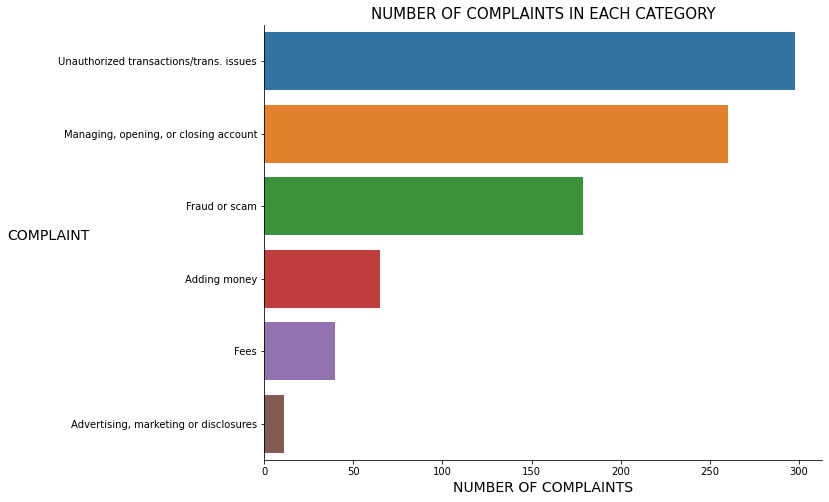

In [31]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='ISSUE', 
                   data=df_pc_issue_and_complaint, 
                   order=df_pc_issue_and_complaint['ISSUE'].value_counts().index)

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, size=14, labelpad=10)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
            
plt.savefig('freq_pc_uncombined_class.png', transparency=True)

This is seriously way too huge. Let's just scope our problem down into more bite-sized chunks our computer can actually handle.

### We observe some aggregated columns here.
Let's drop those columns first. Since we want a more accurate/specific label for our predictions. The columns are:
* Credit card, credit repair services, or other personal consumer reports
* Credit card or prepaid card
* Money transfer, virtual currency, or money service
* Payday loan, title loan, or personal loan

### Section 2.2.2: DataFrame Reduction (else we won't even be able to do processing)

#### Visualizing Leftover Categories (after dropping the ones stated above)

Text(0.5, 0, 'NUMBER OF COMPLAINTS')

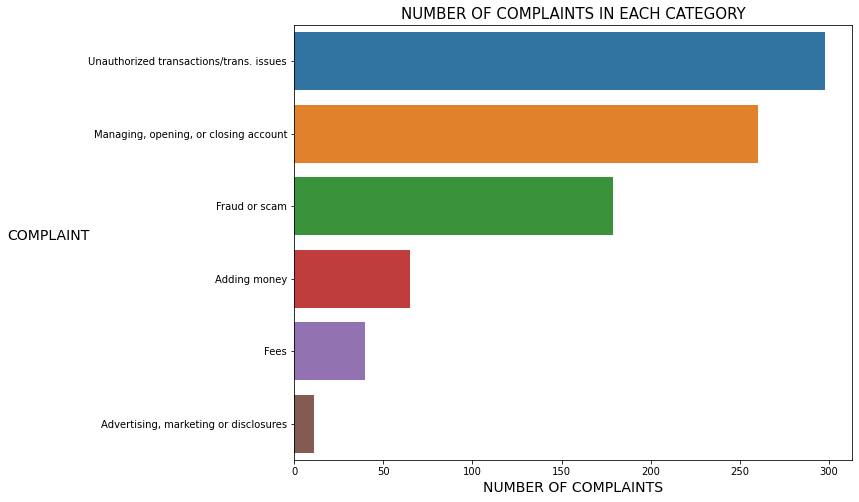

In [32]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='ISSUE', 
                   data=df_pc_issue_and_complaint, 
                   order=df_pc_issue_and_complaint['ISSUE'].value_counts().index)

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

#### Section 2.2.2.3: Leftover Categories Dataframe Reduction

### Section 2.2.3: Data Visualizing on newly combined classes

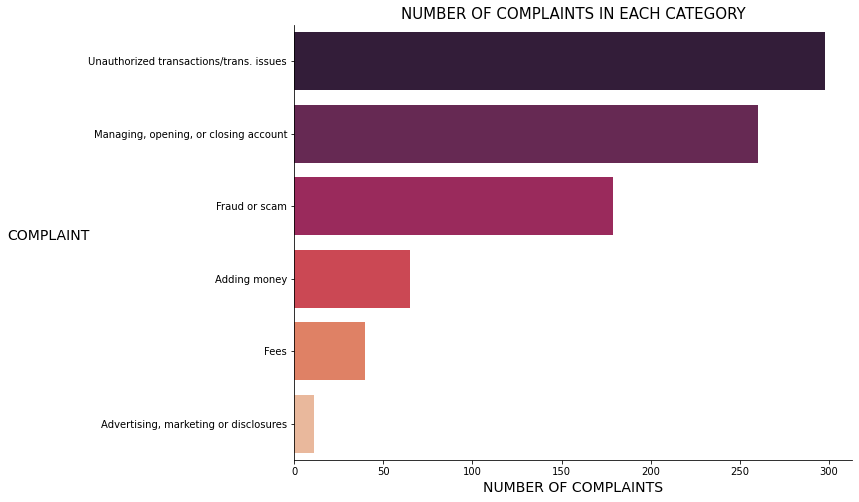

In [33]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='ISSUE', 
                   data=df_pc_issue_and_complaint, 
                   order=df_pc_issue_and_complaint['ISSUE'].value_counts().index,
                   palette='rocket'        # change the color of this graph LATER
                  )
ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
plt.savefig('freq_pc_removed_classes_and_reduced_observations.png', transparency=True)

We can see from the graph that there lies a major class imbalance (again)  
We have to deal with this when we are going to use our model for prediction  
Now we are doing multilabel prediction. HOORAY!

In [34]:
df_pc_issue_and_complaint.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853 entries, 0 to 852
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ISSUE               853 non-null    object
 1   CONSUMER_COMPLAINT  853 non-null    object
dtypes: object(2)
memory usage: 60.0+ KB


### Section 2.2.4: Label Encoding Categories

In [35]:
# Applying encoding to the ISSUE column
df_pc_issue_and_complaint['ISSUE_ID'] = df_pc_issue_and_complaint['ISSUE'].factorize()[0] 

#.factorize[0] arranges the index of each encoded number accordingly to the 
# index of your categorical variables in the ISSUE column


# Creates a dataframe of the ISSUE to their respective ISSUE_ID
category_id_df = df_pc_issue_and_complaint[['ISSUE', 'ISSUE_ID']].drop_duplicates()


# Dictionaries for future use. Creating our cheatsheets for what each encoded label represents.
category_to_id = dict(category_id_df.values) # Creates a ISSUE: ISSUE_ID key-value pair
id_to_category = dict(category_id_df[['ISSUE_ID', 'ISSUE']].values)  # Creates a ISSUE_ID: ISSUE key-value pair

# New dataframe
df_pc_issue_and_complaint.head(10)

ISSUE  ... ISSUE_ID
0  Managing, opening, or closing account  ...        0
1  Managing, opening, or closing account  ...        0
2  Managing, opening, or closing account  ...        0
3  Managing, opening, or closing account  ...        0
4  Managing, opening, or closing account  ...        0
5  Managing, opening, or closing account  ...        0
6  Managing, opening, or closing account  ...        0
7  Managing, opening, or closing account  ...        0
8  Managing, opening, or closing account  ...        0
9  Managing, opening, or closing account  ...        0

[10 rows x 3 columns]

In [36]:
# We still get the same length as per the original df.
len(df_pc_issue_and_complaint)

853

Now that we have encoded our columns, time to move on to the next step -- cleaning the fricken text data  
But let's save our dataframe here so we don't run into memory issues later and we can start from a new starting point fruther down the notebook

### Section 2.2.5: Text Pre-Processing

In [37]:
# Looking at a sample text
sample_complaint = list(df_pc_issue_and_complaint.CONSUMER_COMPLAINT[:5])[4]

# Converting to a list for TfidfVectorizer to use
list_sample_complaint = []
list_sample_complaint.append(sample_complaint)
list_sample_complaint

['prepaid rebate card expired and Citi refuses to reissue card for the balance of the money on the card. \n']

In [38]:
# Observing what words are extracted from a TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf3 = TfidfVectorizer(stop_words='english')
check3 = tf_idf3.fit_transform(list_sample_complaint)

print(tf_idf3.get_feature_names())

['balance', 'card', 'citi', 'expired', 'money', 'prepaid', 'rebate', 'refuses', 'reissue']


Ok so basically, we can trust the stop_word removal from tfidf.   
Through the tests, we see that it removes punctuations and also all the stopwords.   
(I deleted these because they were seriously taking up a lot of space on my jupyter notebook)  
Spellchecker might also mess up some words, especially with bank names like Citi for example  
Thus changing the semantic meaning of the word.  
  
Therefore, we are going to just use tfidf just as it is.  
It's pretty amazing, really.  
  
Great! We can start building some shit!  

# Section 3: Model/Classifier Selection
#### Each model is cross-validated on a stratified 5-fold split train-validation (of 80% of the whole dataset). The remaining 20% data was held out and untouched to simulate how our final chosen model would perform in real-life scenarios

## Section 3.1: Train/StratifiedCV/Test split

In this section, we also prepare the model for text pre-processing. This is handled by our handydandy Tfidfvecotirzer with the stop_words and such. As we have tested above, it also ignores punctuation so it really is quite a catch-all package that cleans our text really well for the purposes of doing text classification

In [39]:
# Split the data into X and y data sets
X, y = df_pc_issue_and_complaint.CONSUMER_COMPLAINT, df_pc_issue_and_complaint.ISSUE_ID
print('X shape:', X.shape, 'y shape:', y.shape)

X shape: (853,) y shape: (853,)


In [40]:
# Split the data into X and y data sets
X, y = df_pc_issue_and_complaint.CONSUMER_COMPLAINT, df_pc_issue_and_complaint.ISSUE_ID
print('X shape:', X.shape, 'y shape:', y.shape)

# For text classification, ALWAYS split data first before vectorizing.
# This is because you don't want to cheat by having features (words) from the test data already being inside your train data
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.2,   # 80% train/cv, 20% test
                                                            stratify=y,
                                                            random_state=seed)
print('X_train', X_train_val.shape)
print('y_train', y_train_val.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X shape: (853,) y shape: (853,)
X_train (682,)
y_train (682,)
X_test (171,)
y_test (171,)


## Section 2.2: Vectorization
#### To turn words into something a machine learning algorithm can understand and process, we need to do something called vectorization.
##### Put simply, this is the process of turning words into multi-dimensional vectors in such a way that the meaning or context of the word is correlated with where that vector points. In a sense, vectorization allows computers to quantify the meaning of words by mapping similar word meanings to similar vector spaces.

In [41]:
# Performing Text Pre-Processing

# Import tfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Text Preprocessing
# The text needs to be transformed to vectors so as the algorithms will be able make predictions. 
# In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight 
# to evaluate how important A WORD is to A DOCUMENT in a COLLECTION OF DOCUMENTS.

# tfidf1 = 1-gram only. 
tfidf1 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5,
                        stop_words='english')

X_train_val_tfidf1 = tfidf1.fit_transform(X_train_val).toarray()
X_test_tfidf1 = tfidf1.transform(X_test)

# tfidf2 = unigram and bigram
tfidf2 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5, 
                        ngram_range=(1,2), # we consider unigrams and bigrams
                        stop_words='english')
X_train_val_tfidf2 = tfidf2.fit_transform(X_train_val).toarray()
X_test_tfidf2 = tfidf2.transform(X_test)


# # StratifiedKFold -> Split 5
# ## We now want to do stratified kfold to preserve the proportion of the category imbalances 
# # (number is split evenly from all the classes)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

## Term Frequency — Inverse Document Frequency Vectorization
#### For this application, we want context-based vectorization. This is where Term frequency inverse document frequency vectorization comes in (TF-IDF). This vectorization method looks at the number of times a word appears in a comment relative to the number of times it appears in other comments. Two things result in a higher TF-IDF score:

   1. Higher frequency of the word within the specific complaint being scored.
   2. Lower frequency of the word across all other complaints.

## Section 3.2: Baseline Model - Train/Stratified CV with MultinomialNB()

In [42]:
print('1-gram number of (rows, features):', X_train_val_tfidf1.shape)

1-gram number of (rows, features): (682, 1161)


### Evaluation Metrics (Accuracy, Recall_macro, Precission_macro, f1_macro, Recall_weighted, Precission_weighted, f1_weighted)
Referrence:
https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2

https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1


In [43]:
def metric_cv_stratified(model, X_train_val, y_train_val, n_splits, name):
    """
    Accepts a Model Object, converted X_train_val and y_train_val, n_splits, name
    and returns a dataframe with various cross-validated metric scores 
    over a stratified n_splits kfold for a multi-class classifier.
    """
    # Start timer
    import timeit
    start = timeit.default_timer()
    
    ### Computations below
    
    # StratifiedKFold
    ## We now want to do stratified kfold to preserve the proportion of the category imbalances 
    # (number is split evenly from all the classes)
    from sklearn.model_selection import StratifiedKFold  # incase user forgest to import
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    # Initializing Metrics
    accuracy = 0.0
    micro_f1 = 0.0
    macro_precision = 0.0
    macro_recall = 0.0
    macro_f1 = 0.0
    weighted_precision = 0.0
    weighted_recall = 0.0
    weighted_f1 = 0.0
#     roc_auc = 0.0    Not considering this score in this case
        
    # Storing metrics
    from sklearn.model_selection import cross_val_score  # incase user forgets to import
    accuracy = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='accuracy'))
#     micro_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_micro'))
    macro_precision = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='precision_macro'))
    macro_recall = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='recall_macro'))
    macro_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_macro'))
    weighted_precision = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='precision_weighted'))
    weighted_recall = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='recall_weighted'))
    weighted_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_weighted'))
    
    # Stop timer
    stop = timeit.default_timer()
    elapsed_time = stop - start
    
    return pd.DataFrame({'Model'    : [name],
                         'Accuracy' : [accuracy],
#                          'Micro F1' : [micro_f1],
                         'Macro Precision': [macro_precision],
                         'Macro Recall'   : [macro_recall],
                         'Macro F1score'  : [macro_f1],
                         'Weighted Precision': [weighted_precision],
                         'Weighted Recall'   : [weighted_recall],
                         'Weighted F1'  : [weighted_f1],
                         'Time taken': [elapsed_time]  # timetaken: to be used for comparison later
                        })

In [44]:
# ## Data Science Story:
# # Testing on MultinomialNB first

# # Initialize Model Object
mnb = MultinomialNB()

results_cv_stratified_1gram = metric_cv_stratified(mnb, X_train_val_tfidf1, y_train_val, 5, 'MultinomialNB1')
results_cv_stratified_2gram = metric_cv_stratified(mnb, X_train_val_tfidf2, y_train_val, 5, 'MultinomialNB2')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

In [45]:
results_cv_stratified_1gram

Model  Accuracy  ...  Weighted F1  Time taken
0  MultinomialNB1  0.439792  ...     0.362754    0.348889

[1 rows x 9 columns]

In [46]:
results_cv_stratified_2gram

Model  Accuracy  ...  Weighted F1  Time taken
0  MultinomialNB2  0.444171  ...     0.365017    0.486723

[1 rows x 9 columns]

## Section 3.3: Further Train/Straitified CV with other Models

### Section 3.3.1: 1-gram

In [47]:
## Testing on all Models using 1-gram 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_1gram = pd.concat([metric_cv_stratified(mnb, X_train_val_tfidf1, y_train_val, 5, 'MultinomialNB1'),
                                           metric_cv_stratified(gnb, X_train_val_tfidf1, y_train_val, 5, 'GaussianNB1'),
                                           metric_cv_stratified(logit, X_train_val_tfidf1, y_train_val, 5, 'LogisticRegression1'),
                                           metric_cv_stratified(randomforest, X_train_val_tfidf1, y_train_val, 5, 'RandomForest1'),
                                           metric_cv_stratified(linearsvc, X_train_val_tfidf1, y_train_val, 5, 'LinearSVC1')
                                          ], axis=0).reset_index()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

In [48]:
results_cv_straitified_1gram

index                Model  ...  Weighted F1  Time taken
0      0       MultinomialNB1  ...     0.362754    0.342259
1      0          GaussianNB1  ...     0.325065    0.651856
2      0  LogisticRegression1  ...     0.418586    7.848485
3      0        RandomForest1  ...     0.300557    6.860255
4      0           LinearSVC1  ...     0.460423    0.991339

[5 rows x 10 columns]

### Linear SVC gives us the highest accuracy of 48%.

In [49]:
# Saving our results because I don't wanna re-train the whole damn thing
with open('results_cv_straitified_1gram_df.pickle', 'wb') as to_write:
  pickle.dump(results_cv_straitified_1gram, to_write)

In [50]:
# Loading our pickled results
with open('results_cv_straitified_1gram_df.pickle', 'rb') as to_read:
    results_cv_straitified_1gram = pickle.load(to_read)

In [51]:
files.download('df_pc_issue_and_complaint.pickle')
files.download('df_pc_issue_and_complaint.pickle')
files.download('results_cv_straitified_1gram_df.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Section 3.3.2: 2-gram (Keep running into memory issues, therefore, this will not be tested anymore)

In [52]:
### Keep running into memory issues with 2-gram. Therefore, will not test it anymore

'''# Testing on all Models using 2-gram 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

# # to concat all models
results_cv_straitified_2gram = pd.concat([metric_cv_stratified(mnb, X_train_val_tfidf2, y_train_val, 5, 'MultinomialNB2'),
                                          metric_cv_stratified(gnb, X_train_val_tfidf2, y_train_val, 5, 'GaussianNB2'),
                                          metric_cv_stratified(logit, X_train_val_tfidf2, y_train_val, 5, 'LogisticRegression2'),
                                          metric_cv_stratified(randomforest, X_train_val_tfidf2, y_train_val, 5, 'RandomForest2'),
                                          metric_cv_stratified(linearsvc, X_train_val_tfidf2, y_train_val, 5, 'LinearSVC2')
                                          ], axis=0).reset_index()'''

"# Testing on all Models using 2-gram \n\n# Initialize Model Object\ngnb = GaussianNB()\nmnb = MultinomialNB()\nlogit = LogisticRegression(random_state=seed)\nknn = KNeighborsClassifier()\ndecisiontree = DecisionTreeClassifier(random_state=seed)\nrandomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)\nlinearsvc = LinearSVC()\n\n# # to concat all models\nresults_cv_straitified_2gram = pd.concat([metric_cv_stratified(mnb, X_train_val_tfidf2, y_train_val, 5, 'MultinomialNB2'),\n                                          metric_cv_stratified(gnb, X_train_val_tfidf2, y_train_val, 5, 'GaussianNB2'),\n                                          metric_cv_stratified(logit, X_train_val_tfidf2, y_train_val, 5, 'LogisticRegression2'),\n                                          metric_cv_stratified(randomforest, X_train_val_tfidf2, y_train_val, 5, 'RandomForest2'),\n                                          metric_cv_stratified(linearsvc, X_train_val_tfidf2, y_train_val,

In [53]:
#results_cv_straitified_2gram

Instead of utilizing Vectorization (Tf-idfVectorizer that we used above), we can utilize WordEmbedding on the complaints before feeding them into our classifiers.
https://towardsdatascience.com/word2vec-skip-gram-model-part-1-intuition-78614e4d6e0b

https://towardsdatascience.com/the-three-main-branches-of-word-embeddings-7b90fa36dfb9

### Section 3.3.3: Using GloVe50d


Each complaint is mapped to a feature vector by averaging the word embeddings of all words in the review. These features are then fed into the defined function above for train/cross validation.

In [54]:
## Using pre-trained GloVe
# download from https://nlp.stanford.edu/projects/glove/

glove_file = glove_dir = 'glove.6B.50d.txt'
w2v_output_file = 'glove.6B.50d.txt.w2v'

# The following utility converts file formats
gensim.scripts.glove2word2vec.glove2word2vec(glove_file, w2v_output_file)

# Now we can load it!
glove_model_50d = gensim.models.KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

# Pickle glove model so we don't have to do the above steps again and keep the damn glove.6b.50d in our folder
with open('glove_model_50d.pickle', 'wb') as to_write:
    pickle.dump(glove_model_50d, to_write)

In [55]:
# Load pickled glove_model
with open('glove_model_50d.pickle', 'rb') as to_read:
    glove_model_50d = pickle.load(to_read)
    
num_features = 50 # depends on the pre-trained model you are loading

In [56]:
def complaint_to_wordlist(review, remove_stopwords=False):
    """
    Convert a complaint to a list of words. Removal of stop words is optional.
    """
    # remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    
    # convert to lower case and split at whitespace
    words = review_text.lower().split()
    
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words    # list of tokenized and cleaned words

In [57]:
# num_features refer to the dimensionality of the model you are using
# model refers to the trained word2vec/glove model
# words refer to the words in a single document/entry

def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),  # creates a zero matrix of (num_features, )
                           dtype="float32")  # pre-initialize (for speed)
    
    # Initialize a counter for the number of words in a complaint
    nwords = 0.
    index2word_set = set(model.index2word)  # words known to the model

    
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:   # for each word in the list of words
        if word in index2word_set:   # if each word is found in the words known to the model
            nwords = nwords + 1.     # add 1 to nwords
            feature_vec = np.add(feature_vec, model[word])   
    
    # Divide by the number of words to get the average 
    if nwords > 0:
        feature_vec = np.divide(feature_vec, nwords)
    
    return feature_vec

In [58]:
# complaints refers to the whole corpus you intend to put in. 
# Therefore you need to append all these info from your df into a list first

def get_avg_feature_vecs(complaints, model, num_features):
    """
    Calculate average feature vectors for ALL complaints
    """
    # Initialize a counter for indexing 
    counter = 0
    
    # pre-initialize (for speed)
    complaint_feature_vecs = np.zeros((len(complaints),num_features), dtype='float32')  
    
    for complaint in complaints: # each complaint is made up of tokenized/cleaned/stopwords removed words
        complaint_feature_vecs[counter] = make_feature_vec(complaint, model, num_features)
        counter = counter + 1
    return complaint_feature_vecs

In [59]:
# Tokenizing and vectorizing our Train_Val Complaints (80%)
clean_train_val_complaints = []
for complaint in X_train_val:
    clean_train_val_complaints.append(complaint_to_wordlist(complaint, True))

X_train_val_glove_features = get_avg_feature_vecs(clean_train_val_complaints, glove_model_50d, num_features)

# Tokenizing and vectorizing our Test Complaints (20%)
clean_test_complaints = []
for complaint in X_train_val:
    clean_test_complaints.append(complaint_to_wordlist(complaint, True))

X_test_glove_features = get_avg_feature_vecs(clean_test_complaints, glove_model_50d, num_features)

In [60]:
## Run the X_train_val_word2vec_features into our defined function for scoring 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_glove50d = pd.concat([
#     metric_cv_stratified(mnb, X_train_val_glove_features, y_train_val, 5, 'MultinomialNB_glove50d'),
     metric_cv_stratified(gnb, X_train_val_glove_features, y_train_val, 5, 'GaussianNB_glove50d'),
     metric_cv_stratified(logit, X_train_val_glove_features, y_train_val, 5, 'LogisticRegression_glove50d'),
     metric_cv_stratified(randomforest, X_train_val_glove_features, y_train_val, 5, 'RandomForest_glove50d'),
     metric_cv_stratified(linearsvc, X_train_val_glove_features, y_train_val, 5, 'LinearSVC_glove50d')
    ], axis=0).reset_index()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

In [61]:
# Saving Results into a DF
with open('results_cv_straitified_glove50d.pickle', 'wb') as to_write:
    pickle.dump(results_cv_straitified_glove50d, to_write)

In [62]:
files.download('results_cv_straitified_glove50d.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
# Opening Results
with open('results_cv_straitified_glove50d.pickle', 'rb') as to_read:
    results_cv_straitified_glove50d = pickle.load(to_read)

In [64]:
results_cv_straitified_glove50d

index                        Model  ...  Weighted F1  Time taken
0      0          GaussianNB_glove50d  ...     0.320056    0.113896
1      0  LogisticRegression_glove50d  ...     0.345495    2.183455
2      0        RandomForest_glove50d  ...     0.304158    8.815153
3      0           LinearSVC_glove50d  ...     0.348967    5.837494

[4 rows x 10 columns]

### Section 3.3.4: Using GloVe100d

In [65]:
del glove_model_50d, results_cv_straitified_glove50d

In [66]:
## Using pre-trained GloVe
# download from https://nlp.stanford.edu/projects/glove/

num_features = 100 # depends on the pre-trained model you are loading

glove_file = glove_dir = 'glove.6B.' + str(num_features) + 'd.txt'
w2v_output_file = 'glove.6B.' + str(num_features) + 'd.txt.w2v'

# The following utility converts file formats
gensim.scripts.glove2word2vec.glove2word2vec(glove_file, w2v_output_file)

# Now we can load it!
glove_model_100d = gensim.models.KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

# Pickle glove model so we don't have to do the above steps again and keep the damn glove.6b.50d in our folder
with open('glove_model_' + str(num_features) + 'd.pickle', 'wb') as to_write:
    pickle.dump(glove_model_100d, to_write)

In [67]:
files.download('glove_model_' + str(num_features) + 'd.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
# Load pickled glove_model
with open('glove_model_100d.pickle', 'rb') as to_read:
    glove_model_100d = pickle.load(to_read)

In [69]:
# For Train_Val Complaints (80%)
clean_train_val_complaints = []
for complaint in X_train_val:
    clean_train_val_complaints.append(complaint_to_wordlist(complaint, True))

X_train_val_glove_features = get_avg_feature_vecs(clean_train_val_complaints, glove_model_100d, num_features)

# For Test Complaints (20%)
clean_test_complaints = []
for complaint in X_train_val:
    clean_test_complaints.append(complaint_to_wordlist(complaint, True))

X_test_glove_features = get_avg_feature_vecs(clean_test_complaints, glove_model_100d, num_features)

KeyboardInterrupt: ignored

In [ ]:
## Run the X_train_val_word2vec_features into our defined function for scoring 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_glove100d = pd.concat([
#     metric_cv_stratified(mnb, X_train_val_glove_features, y_train_val, 5, 'MultinomialNB_glove50d'),
     metric_cv_stratified(gnb, X_train_val_glove_features, y_train_val, 5, 'GaussianNB_glove100d'),
     metric_cv_stratified(logit, X_train_val_glove_features, y_train_val, 5, 'LogisticRegression_glove100d'),
     metric_cv_stratified(randomforest, X_train_val_glove_features, y_train_val, 5, 'RandomForest_glove100d'),
     metric_cv_stratified(linearsvc, X_train_val_glove_features, y_train_val, 5, 'LinearSVC_glove100d')
    ], axis=0).reset_index()

In [ ]:
with open('results_cv_straitified_glove100d.pickle', 'wb') as to_write:
    pickle.dump(results_cv_straitified_glove100d, to_write)

In [ ]:
files.download('results_cv_straitified_glove100d.pickle')

In [ ]:
# Opening Results
with open('results_cv_straitified_glove100d.pickle', 'rb') as to_read:
    results_cv_straitified_glove100d = pickle.load(to_read)

In [ ]:
results_cv_straitified_glove100d

### Section 3.3.5: Using GloVe200d

In [ ]:
del glove_model_100d, results_cv_straitified_glove100d

In [ ]:
## Using pre-trained GloVe
# download from https://nlp.stanford.edu/projects/glove/

num_features = 200 # depends on the pre-trained model you are loading

glove_file = glove_dir = 'glove.6B.' + str(num_features) + 'd.txt'
w2v_output_file = 'glove.6B.' + str(num_features) + 'd.txt.w2v'

# The following utility converts file formats
gensim.scripts.glove2word2vec.glove2word2vec(glove_file, w2v_output_file)

# Now we can load it!
glove_model_200d = gensim.models.KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

# Pickle glove model so we don't have to do the above steps again and keep the damn glove.6b.50d in our folder
with open('glove_model_' + str(num_features) + 'd.pickle', 'wb') as to_write:
    pickle.dump(glove_model_200d, to_write)

In [ ]:
# Load pickled glove_model
with open('glove_model_200d.pickle', 'rb') as to_read:
    glove_model_200d = pickle.load(to_read)

In [ ]:
files.download('glove_model_' + str(num_features) + 'd.pickle')

In [ ]:
# For Train_Val Complaints (80%)
clean_train_val_complaints = []
for complaint in X_train_val:
    clean_train_val_complaints.append(complaint_to_wordlist(complaint, True))

X_train_val_glove_features = get_avg_feature_vecs(clean_train_val_complaints, glove_model_200d, num_features)

# Already run above
# # For Test Complaints (20%)
# clean_test_complaints = []
# for complaint in X_train_val:
#     clean_test_complaints.append(complaint_to_wordlist(complaint, True))

# X_test_glove_features = get_avg_feature_vecs(clean_test_complaints, glove_model_200d, num_features)

In [ ]:
## Run the X_train_val_word2vec_features into our defined function for scoring 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_glove200d = pd.concat([
#     metric_cv_stratified(mnb, X_train_val_glove_features, y_train_val, 5, 'MultinomialNB_glove50d'),
     metric_cv_stratified(gnb, X_train_val_glove_features, y_train_val, 5, 'GaussianNB_glove200d'),
     metric_cv_stratified(logit, X_train_val_glove_features, y_train_val, 5, 'LogisticRegression_glove200d'),
     metric_cv_stratified(randomforest, X_train_val_glove_features, y_train_val, 5, 'RandomForest_glove200d'),
     metric_cv_stratified(linearsvc, X_train_val_glove_features, y_train_val, 5, 'LinearSVC_glove200d')
    ], axis=0).reset_index()

In [ ]:
with open('results_cv_straitified_glove200d.pickle', 'wb') as to_write:
    pickle.dump(results_cv_straitified_glove200d, to_write)

In [ ]:
files.download('results_cv_straitified_glove200d.pickle')

In [ ]:
# Opening Results
with open('results_cv_straitified_glove200d.pickle', 'rb') as to_read:
    results_cv_straitified_glove200d = pickle.load(to_read)

In [ ]:
results_cv_straitified_glove200d

### Section 3.3.6: Using GloVe300d

In [ ]:
del glove_model_200d, results_cv_straitified_glove200d

In [ ]:
## Using pre-trained GloVe
# download from https://nlp.stanford.edu/projects/glove/

num_features = 300 # depends on the pre-trained model you are loading

glove_file = glove_dir = 'glove.6B.' + str(num_features) + 'd.txt'
w2v_output_file = 'glove.6B.' + str(num_features) + 'd.txt.w2v'

# The following utility converts file formats
gensim.scripts.glove2word2vec.glove2word2vec(glove_file, w2v_output_file)

# Now we can load it!
glove_model_300d = gensim.models.KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

# Pickle glove model so we don't have to do the above steps again and keep the damn glove.6b.50d in our folder
with open('glove_model_' + str(num_features) + 'd.pickle', 'wb') as to_write:
    pickle.dump(glove_model_300d, to_write)

In [ ]:
files.download('glove_model_' + str(num_features) + 'd.pickle')

In [ ]:
# Load pickled glove_model
with open('glove_model_300d.pickle', 'rb') as to_read:
    glove_model_300d = pickle.load(to_read)

In [ ]:
# For Train_Val Complaints (80%)
clean_train_val_complaints = []
for complaint in X_train_val:
    clean_train_val_complaints.append(complaint_to_wordlist(complaint, True))

X_train_val_glove_features = get_avg_feature_vecs(clean_train_val_complaints, glove_model_300d, num_features)

# Already run above
# # For Test Complaints (20%)
# clean_test_complaints = []
# for complaint in X_train_val:
#     clean_test_complaints.append(complaint_to_wordlist(complaint, True))

# X_test_glove_features = get_avg_feature_vecs(clean_test_complaints, glove_model_200d, num_features)

In [ ]:
## Run the X_train_val_word2vec_features into our defined function for scoring 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_glove300d= pd.concat([
#     metric_cv_stratified(mnb, X_train_val_glove_features, y_train_val, 5, 'MultinomialNB_glove50d'),
     metric_cv_stratified(gnb, X_train_val_glove_features, y_train_val, 5, 'GaussianNB_glove300d'),
     metric_cv_stratified(logit, X_train_val_glove_features, y_train_val, 5, 'LogisticRegression_glove300d'),
     metric_cv_stratified(randomforest, X_train_val_glove_features, y_train_val, 5, 'RandomForest_glove300d'),
     metric_cv_stratified(linearsvc, X_train_val_glove_features, y_train_val, 5, 'LinearSVC_glove300d')
    ], axis=0).reset_index()

In [ ]:
with open('results_cv_straitified_glove300d.pickle', 'wb') as to_write:
    pickle.dump(results_cv_straitified_glove300d, to_write)

In [ ]:
files.download('results_cv_straitified_glove300d.pickle')

In [ ]:
# Opening Results
with open('results_cv_straitified_glove300d.pickle', 'rb') as to_read:
    results_cv_straitified_glove300d = pickle.load(to_read)

In [ ]:
results_cv_straitified_glove300d

### Section 3.3.7: Using GoogleNews Word2Vec300d

In [ ]:
del glove_model_300d, results_cv_straitified_glove300d

In [ ]:
## Using pre-trained GoogleNews Word2Vec
# download from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

num_features = 300 # depends on the pre-trained model you are loading

# Path to where the word2vec file lives
google_vec_file = 'GoogleNews-vectors-negative300.bin'

# Load it!  This might take a few minutes...
word2vec_model_300d = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)
# it is just loading all the different weights (embedding) into python


# Pickle word2vec 300d model so we don't have to do the above steps again and keep the damn file in our folder
with open('word2vec_model_' + str(num_features) + 'd.pickle', 'wb') as to_write:
    pickle.dump(word2vec_model_300d, to_write)

In [ ]:
files.download('word2vec_model_' + str(num_features) + 'd.pickle')

In [ ]:
# Load pickled glove_model
with open('word2vec_model_300d.pickle', 'rb') as to_read:
    word2vec_model_300d = pickle.load(to_read)

In [ ]:
# For Train_Val Complaints (80%)
clean_train_val_complaints = []
for complaint in X_train_val:
    clean_train_val_complaints.append(complaint_to_wordlist(complaint, True))

X_train_val_glove_features = get_avg_feature_vecs(clean_train_val_complaints, word2vec_model_300d, num_features)

# Already run above
# # For Test Complaints (20%)
# clean_test_complaints = []
# for complaint in X_train_val:
#     clean_test_complaints.append(complaint_to_wordlist(complaint, True))

# X_test_glove_features = get_avg_feature_vecs(clean_test_complaints, glove_model_200d, num_features)

In [ ]:
## Run the X_train_val_word2vec_features into our defined function for scoring 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_word2vec300d= pd.concat([
#     metric_cv_stratified(mnb, X_train_val_glove_features, y_train_val, 5, 'MultinomialNB_glove50d'),
     metric_cv_stratified(gnb, X_train_val_glove_features, y_train_val, 5, 'GaussianNB_word2vec300d'),
     metric_cv_stratified(logit, X_train_val_glove_features, y_train_val, 5, 'LogisticRegression_word2vec300d'),
     metric_cv_stratified(randomforest, X_train_val_glove_features, y_train_val, 5, 'RandomForest_word2vec300d'),
     metric_cv_stratified(linearsvc, X_train_val_glove_features, y_train_val, 5, 'LinearSVC_word2vec300d')
    ], axis=0).reset_index()

In [ ]:
with open('results_cv_straitified_word2vec300d.pickle', 'wb') as to_write:
    pickle.dump(results_cv_straitified_word2vec300d, to_write)

In [ ]:
files.download('results_cv_straitified_word2vec300d.pickle')

In [ ]:
# Opening Results
with open('results_cv_straitified_word2vec300d.pickle', 'rb') as to_read:
    results_cv_straitified_word2vec300d = pickle.load(to_read)

In [ ]:
results_cv_straitified_word2vec300d

In [ ]:
del word2vec_model_300d, results_cv_straitified_word2vec300d

### Section 3.3.8: Compiling Results

In [ ]:
results_compiled.columns

In [ ]:
results_compiled = pd.concat([results_cv_straitified_1gram,
                           results_cv_straitified_glove50d,
                           results_cv_straitified_glove100d,
                           results_cv_straitified_glove200d,
                           results_cv_straitified_glove300d,
                           results_cv_straitified_word2vec300d]).reset_index().drop(['level_0','index'],axis=1)

In [ ]:
with open('results_compiled.pickle', 'wb') as to_write:
    pickle.dump(results_compiled, to_write)

results_compiled

#### Sorting in Descending order by Accuracy

In [ ]:
# Sorting results to see which one gives us the best results
results_compiled_sorted_by_accuracy = results_compiled.sort_values(by='Accuracy', ascending=False)

with open('results_compiled_sorted_by_accuracy.pickle', 'wb') as to_write:
    pickle.dump(results_compiled_sorted_by_accuracy, to_write)

results_compiled_sorted_by_accuracy

In [ ]:
files.download('results_compiled_sorted_by_accuracy.pickle')

In [ ]:
# Retrieving the Model that provides the highest Accuracy
results_highest_accuracy = results_compiled[results_compiled.Accuracy == results_compiled.Accuracy.max()]

with open('results_highest_accuracy.pickle', 'wb') as to_write:
    pickle.dump(results_highest_accuracy, to_write)

results_highest_accuracy

In [ ]:
# We see from the above that LogisiticRegression and LinearSVC on 1-gram gives pretty good results.
# But LogReg is the best. So let's go with that!

# Now let us do the final test!!
# Pretty decent accuracy, actually.
# I want to try 2-gram but my computer just simply won't be able to handle it

# Section 4: Final Test - 80% Train/Test split

## Section 4.1: Splitting to 80% Train and 20% unseen data
#### Remember the 20% data we heldout earlier that we didn’t use in the cross-validation? Here comes the part where we use it as an estimate as to how well our model will perform on unseen data (i.e. how it would perform in real-life scenarios).

In [70]:
# Split the data into X and y data sets
X, y = df_pc_issue_and_complaint.CONSUMER_COMPLAINT, df_pc_issue_and_complaint.ISSUE
print('X shape:', X.shape, 'y shape:', y.shape)

# For text classification, ALWAYS split data first before vectorizing.
# This is because you don't want to cheat by having features (words) from the test data already being inside your train data
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.2,   # 80% train/cv, 20% test
                                                            stratify=y,
                                                            random_state=seed)
print('X_train', X_train_val.shape)
print('y_train', y_train_val.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X shape: (853,) y shape: (853,)
X_train (682,)
y_train (682,)
X_test (171,)
y_test (171,)


In [71]:
y_train_val

300                              Fraud or scam
510    Unauthorized transactions/trans. issues
27       Managing, opening, or closing account
343                              Fraud or scam
717    Unauthorized transactions/trans. issues
                        ...                   
467    Unauthorized transactions/trans. issues
88       Managing, opening, or closing account
380                              Fraud or scam
233      Managing, opening, or closing account
116      Managing, opening, or closing account
Name: ISSUE, Length: 682, dtype: object

In [72]:
# tfidf1 = 1-gram only. 
tfidf1 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5,
                        stop_words='english')
X_train_val_tfidf1 = tfidf1.fit_transform(X_train_val).toarray()
X_test_tfidf1 = tfidf1.transform(X_test)

In [73]:
# Initializing our chosen logreg model
logit = LinearSVC()
clf = CalibratedClassifierCV(logit) 
lnsvc_finalized = clf.fit(X_train_val_tfidf1, y_train_val)

# Fitting our model
logit_finalized = logit.fit(X_train_val_tfidf1, y_train_val)

# Obtaining prediction
y_pred = logit_finalized.predict(X_test_tfidf1)

In [74]:
# Pickle trained Model for use in Flask App
with open('pc_logit_finalized.pickle', 'wb') as to_write:
    pickle.dump(logit_finalized, to_write)
with open('pc_lnsvc_finalized.pickle', 'wb') as to_write:
    pickle.dump(lnsvc_finalized, to_write)

In [75]:
files.download('pc_logit_finalized.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    
    # Creates a dataframe of the ISSUE to their respective ISSUE_ID
    category_id_df = df_pc_issue_and_complaint[['ISSUE', 'ISSUE_ID']].drop_duplicates()

    # Dictionaries for future use. Creating our cheatsheets for what each encoded label represents.
    category_to_id = dict(category_id_df.values) # Creates a ISSUE: ISSUE_ID key-value pair
    id_to_category = dict(category_id_df[['ISSUE_ID', 'ISSUE']].values)  # Creates a ISSUE_ID: ISSUE key-value pair

    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    g= sns.heatmap(conf_mat, 
                   annot=True, annot_kws={"size":10},
                   cmap=plt.cm.Reds, square=True,
                   fmt='d',
                   xticklabels=category_id_df.ISSUE.values, 
                   yticklabels=category_id_df.ISSUE.values)
    
#     # Changing the size of the xticks and ytick labels
#     ax.set_yticklabels(g.get_yticklabels(), rotation=90, size=10);
#     ax.set_xticklabels(g.get_xticklabels(), size=10);
    
    # Changing axis orientation & setting titles
    ax.set_xlabel('Prediction', size=15)
    ax.set_ylabel('Actual', rotation=0, labelpad=40,size=15)

#     plt.title("CONFUSION MATRIX - {}\n".format(name), size=16);
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

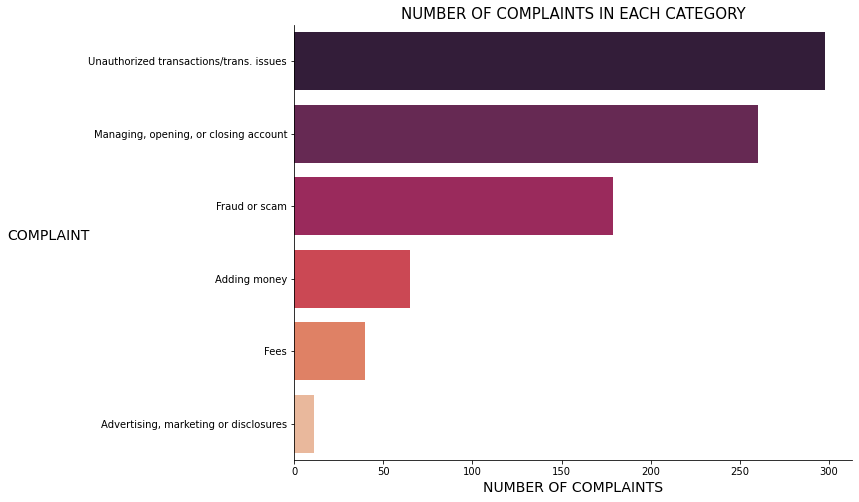

In [77]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='ISSUE', 
                   data=df_pc_issue_and_complaint, 
                   order=df_pc_issue_and_complaint['ISSUE'].value_counts().index,
                   palette='rocket'        # change the color of this graph LATER
                  )
logit_finalized
ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
plt.savefig('freq_pc_removed_classes_and_reduced_observations.png', transparency=True)

---------------------------------------------------------
LogisticRegression (1-gram) 80% TRAIN/20% TEST SCORES:
---------------------------------------------------------


Final Test Accuracy Score (also micro F1) for LogisticRegression: 0.4327


Macro Precision Score for LogisticRegression: 0.3639
Macro Recall Score for LogisticRegression: 0.3316
Macro F1 score = 0.3425


Micro Precision Score for LogisticRegression: 0.4327
Micro Recall Score for LogisticRegression: 0.4327
Micro F1 score = 0.4327


Weighted Precision Score for LogisticRegression: 0.4152
Weighted Recall Score for LogisticRegression: 0.4327
Weighted F1 score = 0.4200


Classification report for LogisticRegression (1-gram):
                                          precision    recall  f1-score   support

  Managing, opening, or closing account       0.33      0.23      0.27        13
                          Fraud or scam       0.00      0.00      0.00         2
Unauthorized transactions/trans. issues       0.67      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


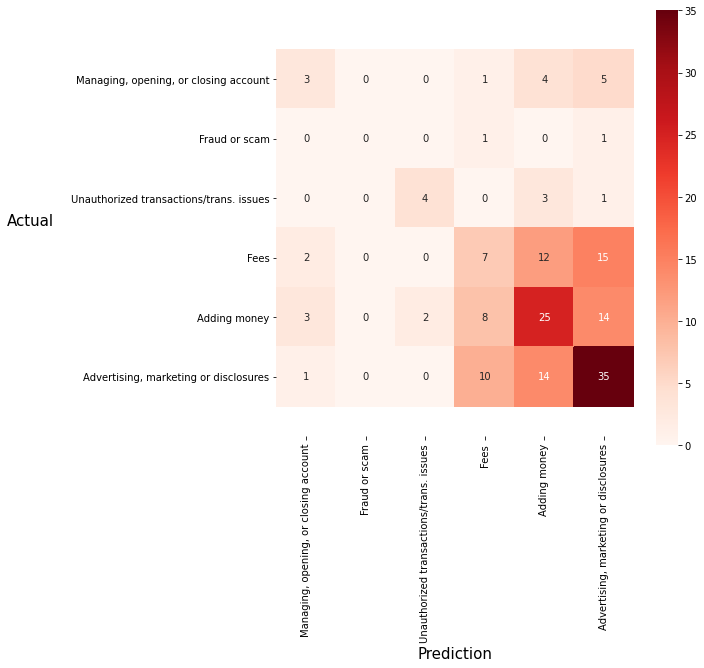

In [78]:
'''with open('results_highest_accuracy.pickle', 'rb') as to_read:
    results_highest_accuracy = pickle.load(to_read)

results_highest_accuracy'''

# Score model
print("---------------------------------------------------------")
print("LogisticRegression (1-gram) 80% TRAIN/20% TEST SCORES:")
print("---------------------------------------------------------")
print('\n')
#print('Train/Cross-Validation Test Accuracy Score (also micro F1) for LogisticRegression: {:.4f}'.format(results_highest_accuracy.Accuracy.max()))
print('Final Test Accuracy Score (also micro F1) for LogisticRegression: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('\n')
print('Macro Precision Score for LogisticRegression: {:.4f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall Score for LogisticRegression: {:.4f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1 score = {:.4f}'.format(f1_score(y_test, y_pred, average='macro')))
print('\n')
print('Micro Precision Score for LogisticRegression: {:.4f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall Score for LogisticRegression: {:.4f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1 score = {:.4f}'.format(f1_score(y_test, y_pred, average='micro')))
print('\n')
print('Weighted Precision Score for LogisticRegression: {:.4f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall Score for LogisticRegression: {:.4f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1 score = {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\n')
print('Classification report for LogisticRegression (1-gram):\n {}'.format(classification_report(y_test, 
                                                                                             y_pred,
                                                                                             target_names=df_pc_issue_and_complaint.ISSUE.unique())))
print('Confusion Matrix for LogisticRegression (1-gram):\n'.format(conf_matrix(y_test, y_pred)))

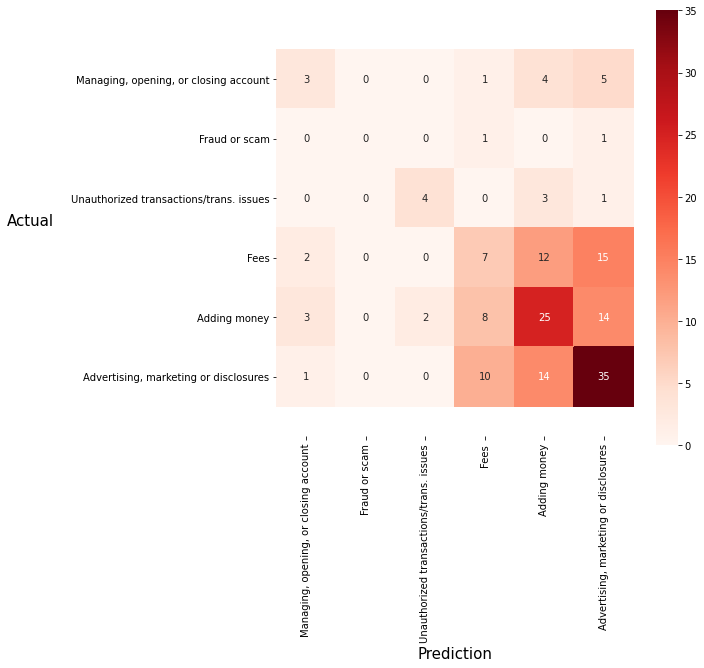

In [79]:
conf_matrix(y_test, y_pred)
plt.savefig('confusion_matrix', transparent=True)

In [80]:
# Just leaving this here for presentation purposes. 
# However, we are already doing the stratified split in the function itself

# StratifiedKFold
# We now want to do stratified kfold to preserve the proportion of the category imbalances 
# (number is split evenly from all the classes)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Section 5: Testing out Predictions on Random Complaints

In [81]:
# These are the ONLY packages we need to use from this point forward!
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [82]:
# Loading our saved models
# Consider training on the whole data instead now?
fitted_tfidf_to_use = tfidf1
# Pickle trained Model for use in Flask App
with open('pc_fitted_tfidf_to_use.pickle', 'wb') as to_write:
    pickle.dump(fitted_tfidf_to_use, to_write)
with open('pc_fitted_tfidf_to_use.pickle', 'rb') as to_read:  # loading the fitted tfidf with our 80% trained data
    fitted_tfidf_to_use = pickle.load(to_read)
    
with open('pc_logit_finalized.pickle', 'rb') as to_read:  # loading our model
    logit_finalized = pickle.load(to_read)

In [83]:
files.download('pc_fitted_tfidf_to_use.pickle')
files.download('pc_logit_finalized.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Section 5.1: Random Complaint 1

In [84]:
# Using our models

complaint = """
omg where is my money
aosidnoiandnaiosdnasd This is bullshit!! where is my money!!!
I TRANSFERRED IT BUT IT JUST DISAPPEARED INTO THIN AIR.
WHAT KIND OF A BANK ARE YOU?
ARE YOU A BANK OR A THIEF?"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint = fitted_tfidf_to_use.transform([complaint])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint)
pred_probs = lnsvc_finalized.predict_proba(new_vectorized_complaint).flat
print(pred_probs)
for item in pred_probs:
    print(item)
y_customized_prediction[0]

0.11419744299886156
0.018225156496388766
0.0014158530666948804
0.19015114929249802
0.19852028290649423
0.47749011523906254


'Unauthorized transactions/trans. issues'

## Section 5.1: Random Complaint 2

In [85]:
# Using our models

complaint_2 = """
I borrowed money from you guys but it seems that the interest terms are unclear?
Please shed some more light on this because i seem to be overcharged this month and I don't want to pay more than I should
"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint_2 = fitted_tfidf_to_use.transform([complaint_2])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint_2)
y_customized_prediction

array(['Managing, opening, or closing account'], dtype=object)

In [86]:
# Not bad! Our model actually does do a pretty good job at predicting

## Section 5.2: Random Complaint 3 with no relevance at all

What about _completely_ irrelevant topics?

In [87]:
# Using our models

complaint_3 = """
I love macdonalds"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint_3 = fitted_tfidf_to_use.transform([complaint_3])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint_3)
y_customized_prediction

array(['Unauthorized transactions/trans. issues'], dtype=object)

## Section 5.3: Random Complaint 4 with no relevance at all

In [88]:
# Using our models

complaint_4 = """
Pair programming is not fun"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint_4 = fitted_tfidf_to_use.transform([complaint_4])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint_4)
y_customized_prediction

array(['Unauthorized transactions/trans. issues'], dtype=object)

### Comments:
It seems like everything that has no relevance tends to be classified as Credit card.  
So yes - there are cases therein which the model can incorrectly classify the Complaint.  
However, although our model is not going to be correct 100% of the time, it does do a pretty good job.  
It can handle very weird complaints where we throw in a complain that doesn't make a lot of sense.  
  
### Breaking our Model down:
It's great that we know that our model can do classifcation, but HOW does it do it? Let's dissect it and check what key words the model looks out for to classify a complaint.

# Section 6: Highest Occuring Words in each column

In [89]:
# tfidf2 = unigram and bigram
tfidf2 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5, 
                        ngram_range=(1,2), # we consider unigrams and bigrams
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf2.fit_transform(df_pc_issue_and_complaint.CONSUMER_COMPLAINT).toarray()
# Labelling our data
labels = df_pc_issue_and_complaint.ISSUE_ID

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 853 complaints is represented by 2345 features (TF-IDF score of unigrams and bigrams)


In [90]:
category_to_id

{'Adding money': 4,
 'Advertising, marketing or disclosures': 5,
 'Fees': 3,
 'Fraud or scam': 1,
 'Managing, opening, or closing account': 0,
 'Unauthorized transactions/trans. issues': 2}

In [91]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf2.get_feature_names())[indices]
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Adding money:
  * Most Correlated Unigrams are: added, loaded, load
  * Most Correlated Bigrams are: xxxx load, load xxxx, deposit money

==> Advertising, marketing or disclosures:
  * Most Correlated Unigrams are: understood, technology, transition
  * Most Correlated Bigrams are: countless hours, old xxxx, phone rush

==> Fees:
  * Most Correlated Unigrams are: issuance, inactivity, fee
  * Most Correlated Bigrams are: inactivity fees, 12 months, 00 month

==> Fraud or scam:
  * Most Correlated Unigrams are: claimed, fraud, scam
  * Most Correlated Bigrams are: card numbers, work money, prepaid mastercard

==> Managing, opening, or closing account:
  * Most Correlated Unigrams are: paypal, close, limited
  * Most Correlated Bigrams are: paypal account, able access, close account

==> Unauthorized transactions/trans. issues:
  * Most Correlated Unigrams are: unauthorized, merchant, dispute
  * Most Correlated Bigrams are: charge xxxx, dispute charges, transaction xxxx


### Section 69.1: Word Cloud (Most frequently occuring words depicted in a picture)

# Section 7: Flask App

In [92]:
## Do a flask app that returns the predicted category
# and the percentage probability of each category
# with an input

### Please refer to the flask_app folder if you are interested in finding out how to create the app!